In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine as ce
from sqlalchemy import inspect
from pathlib import Path
import re
import contractions
import tqdm
import tempfile

# Part 0: Loading the files

In [2]:
# text_file_df = pd.read_csv(r"text_file_1600_1700.csv")
DATA = Path("books.db")
engine = ce("sqlite:///"+str(DATA))
inspector = inspect(engine)
text_file_df = pd.read_sql("text_files", con = engine)

# Part 1: Convert book files into sentences

In [3]:
# Convert the book text into lowercase
filtered_text = pd.DataFrame()
filtered_text['text'] = text_file_df['text'].apply(lambda x: list(filter(None, x.lower().split("\n"))))

In [4]:
gender_lst = ['woman', 'women', 'female', 'she', 'her', 'hers', 'man', 'men', 'male', 'he', 'his', 'him']
woman_lst = ['woman', 'women', 'female', 'she', 'her', 'hers']
man_lst = ['man', 'men', 'male', 'he', 'his', 'him']

In [5]:
home_category = ['home', 'homes', 'domestic', 'household', 'households', 'chore', 'chores', 'family', 'families']
work_category = ['work', 'works', 'worked', 'labor', 'worker', 'workers', 'economy', 'trade', 'trades', \
                 'business', 'businesses', 'job', 'jobs', 'company', 'companies', 'industry', 'industries', \
                 'pay', 'pays', 'paid', 'working', 'salary', 'salaries', 'wage', 'wages']
achievement_category = ['power', 'authority', 'authorities', 'achievement', 'control', 'controls', 'controlled',\
                        'won', 'win', 'wins', 'powerful', 'success', 'succeed', 'succeeded', 'successful',\
                        'better', 'effort', 'efforts', 'plan', 'plans', 'planned', 'try', 'tries', 'tried', 'leader']

In [6]:
len(filtered_text)

10171

In [7]:
# Filter out the books that doesn't contain gender words and drop them
new_filtered_text = pd.DataFrame()
new_filtered_text['text'] = filtered_text['text'].apply(lambda x: [sentence for sentence in x \
    if any(word in sentence.split() for word in gender_lst)
    and any(word in sentence.split() for word in home_category)\
    or any(word in sentence.split() for word in work_category)\
    or any(word in sentence.split() for word in achievement_category)])

In [8]:
sentence_count = 0
empty_index = [] # list that contains index of unused books
for index in range(len(new_filtered_text)):
    if len(new_filtered_text['text'][index]) == 0:
        empty_index.append(index)
    sentence_count += len(new_filtered_text['text'])

print(empty_index)
filtered_text = filtered_text.drop(empty_index)
filtered_text = filtered_text.reset_index(drop = True)

[18, 27, 31, 71, 244, 317, 415, 502, 676, 682, 696, 722, 793, 806, 814, 821, 826, 859, 874, 880, 890, 905, 942, 968, 978, 991, 1015, 1018, 1056, 1063, 1065, 1077, 1078, 1079, 1084, 1106, 1116, 1124, 1135, 1145, 1163, 1171, 1179, 1229, 1235, 1239, 1246, 1249, 1254, 1261, 1265, 1270, 1273, 1275, 1280, 1290, 1292, 1309, 1315, 1318, 1320, 1325, 1339, 1341, 1344, 1349, 1360, 1385, 1433, 1445, 1449, 1450, 1465, 1516, 1530, 1582, 1678, 1679, 1694, 1738, 1758, 1769, 1771, 1808, 1821, 1836, 1838, 1839, 1860, 1877, 1884, 1891, 1896, 1901, 1904, 1919, 1920, 1930, 1933, 1938, 1983, 2009, 2028, 2036, 2054, 2069, 2090, 2111, 2128, 2133, 2175, 2182, 2242, 2262, 2306, 2309, 2322, 2341, 2392, 2417, 2433, 2455, 2458, 2464, 2543, 2546, 2576, 2586, 2610, 2613, 2667, 2679, 2681, 2773, 2790, 2792, 2806, 2819, 2826, 2828, 2836, 2858, 2860, 2886, 2903, 2922, 2923, 2924, 2928, 2932, 2940, 2941, 2943, 2944, 2947, 2948, 2949, 2978, 3021, 3060, 3082, 3102, 3103, 3112, 3150, 3185, 3187, 3198, 3233, 3243, 3287, 334

In [9]:
len(filtered_text)

9599

In [10]:
sentences_df = pd.DataFrame(columns=['text'])

In [11]:
sentences_df = filtered_text.text.apply(pd.Series).stack().reset_index(drop=True).to_frame('text')

sentences_df

,text
0,the song of roland
1,anonymous
2,the song of roland
3,"anonymous old french epic, dating perhaps as e..."
4,11th century.
...,...
7176028,why the question now affected him as other he ...
7176029,"he could only this time meet it otherwise. ""e..."
7176030,"""so i thought. then you shall succeed. and t..."
7176031,"""ah, dear lady!"" he kindly breathed."


# Part 2: Preprocessing and Cleaning

In [12]:
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
lemmatizer = WordNetLemmatizer()

In [15]:
sentences_df['text'] = sentences_df['text'].replace(r'[^A-Za-z0-9 \']+', '', regex=True)
sentences_df['text'] = sentences_df['text'].replace(r'  ', ' ', regex=True)

# for index, content in enumerate(sentences_df['text']):
#    if '\'' not in content:
#        continue
#    sentences_df.replace(content, contractions.fix(content), inplace=True)

In [16]:
sentences_df.head(10)

,text
0,the song of roland
1,anonymous
2,the song of roland
3,anonymous old french epic dating perhaps as ea...
4,11th century
5,i
6,charles the king our lord and sovereign
7,full seven years hath sojourned in spain
8,conquered the land and won the western main
9,now no fortress against him doth remain


space = ' '
stop_words = set(stopwords.words('english'))
for index, content in enumerate(sentences_df['text']):
    filtered = []
    word_tokens = word_tokenize(content)
    for w in word_tokens:
        if w not in stop_words:
            # perform lemmatization
            final_w = lemmatizer.lemmatize(w)
            filtered.append(final_w)
    filtered_join = space.join(filtered)
    sentences_df.at[index, 'text'] = filtered_join

In [17]:
sentences_df.head(10)

,text
0,the song of roland
1,anonymous
2,the song of roland
3,anonymous old french epic dating perhaps as ea...
4,11th century
5,i
6,charles the king our lord and sovereign
7,full seven years hath sojourned in spain
8,conquered the land and won the western main
9,now no fortress against him doth remain


In [18]:
for i, row in sentences_df.iterrows():
    if any(word in row['text'].split() for word in woman_lst):
        wordlist = [x for x in row['text'].split() if x in woman_lst]
        for target_word in wordlist:
            row['text'] = re.sub(r"\b%s\b" % target_word, 'woman', row['text'])

    elif any(word in row['text'].split() for word in man_lst):
        wordlist = [x for x in row['text'].split() if x in man_lst]
        for target_word in wordlist:
            row['text'] = re.sub(r"\b%s\b" % target_word, 'man', row['text'])

In [19]:
sentences_df.head(10)

,text
0,the song of roland
1,anonymous
2,the song of roland
3,anonymous old french epic dating perhaps as ea...
4,11th century
5,i
6,charles the king our lord and sovereign
7,full seven years hath sojourned in spain
8,conquered the land and won the western main
9,now no fortress against man doth remain


# Create Word2Vec Model

In [20]:
import gensim.models
from gensim.test.utils import datapath
from gensim import utils

sentence_list = sentences_df['text'].to_list()

C:\Users\tommy\anaconda3\envs\new-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [21]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        for line in sentence_list:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

# Calculate Similarity

In [22]:
import gensim.models

sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences)

In [23]:
pairs=[]

for i in range(len(home_category)):
    pairs.append((home_category[i], 'home'))
    
for i in range(len(work_category)):
    pairs.append((work_category[i], 'work'))
    
for i in range(len(achievement_category)):
    pairs.append((achievement_category[i], 'achievement'))

simi_table = pd.DataFrame(columns = ['category', 'word', 'man', 'woman'])
    
for word, category in pairs:
    try:
        simi_table = simi_table.append({'category': category, 'word': word, 'man': model.wv.similarity('man', word), 
                                        'woman': model.wv.similarity('woman', word)}, ignore_index=True)
    except:
        continue

simi_table

,category,word,man,woman
0,home,home,0.178137,0.231127
1,home,homes,-0.072067,-0.033595
2,home,domestic,0.052515,0.033304
3,home,household,0.057850,0.112715
4,home,households,0.059447,0.027889
5,home,chore,0.051978,0.059124
6,home,chores,-0.049610,-0.083327
7,home,family,0.137740,0.121219
8,home,families,0.114594,0.050857
9,work,work,0.153523,0.111355


In [24]:
simi_table.to_csv('Average.csv', index=False)

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

simi_home = simi_table.loc[simi_table['category']=='home']
simi_work = simi_table.loc[simi_table['category']=='work']
simi_achievement = simi_table.loc[simi_table['category']=='achievement']

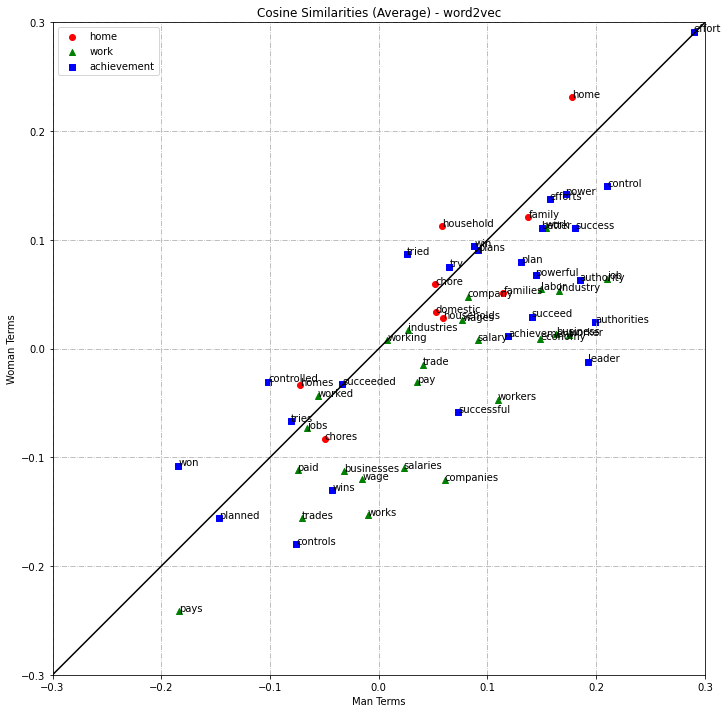

In [26]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

plt.scatter(simi_home['man'], simi_home['woman'], marker='o', label="home", c='r')
plt.scatter(simi_work['man'], simi_work['woman'], marker='^', label="work", c='g')
plt.scatter(simi_achievement['man'], simi_achievement['woman'], marker='s', label="achievement", c='b')

x = np.linspace(-0.3,0.3,100)
plt.plot(x, x, c='black')
plt.legend(loc='best')

plt.title('Cosine Similarities (Average) - word2vec')
plt.xlabel('Man Terms')
plt.ylabel('Woman Terms')

plt.xlim([-0.3,0.3])
plt.ylim([-0.3,0.3])

for i in range(len(simi_table)):
    ax.annotate(simi_table['word'][i], xy=(simi_table['man'][i], simi_table['woman'][i]))

ax.set_aspect('equal', adjustable='box')

plt.grid(linestyle='-.')

plt.savefig("Cosine Similarities (Average) - word2vec.png")
plt.show()

In [28]:
model.save("word2vec.model")